In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
from matplotlib import patches
import pandas as pd

from astropy import table
from astropy.io import fits
from astropy import units as u
from astropy import coordinates, cosmology
from astropy import wcs

from astroquery.mast import Catalogs
from astroquery.skyview import SkyView

from ekfobs import planning
from ekfphys import observer, calibrations
from ekfplot import plot as ek
from ekfparse import query

from agrias import utils, photometry
from skipper import observe

import sys
sys.path.append('../scripts')
import reader

cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [4]:
def fha_from_sfr ( sample, z=0.08):
    dlum = cosmo.luminosity_distance(z).to(u.cm).value
    return calibrations.SFR2LHa(10.**sample['logsfr']) / (4*np.pi*dlum**2)
    

In [5]:
#merian = table.Table(fits.getdata("/Users/kadofong/Downloads/Merian_DR1_photoz_EAZY_v2.0.fits", 1))#.to_pandas ()
ms = reader.merianselect ( maglim=21.5,)

[merianselect] Only choosing sources with m_i < 21.5
[merianselect] only choosing sources with cmodel/gaap(i) > 1.3
[merianselect] only choosing sources with griz photometry


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/astropy/cosmology/flrw/base.py:1351: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in

In [6]:
lha_cat = calibrations.SFR2LHa( 10.**(ms['logssfr']+ ms['logmass']))
fha_cat = lha_cat / (4.*np.pi * cosmo.luminosity_distance(ms['z500'].values).to(u.cm).value**2)

In [7]:
palomar = observe.ObservingSite('palomar')
lco = observe.ObservingSite('CTIO')

# Mass-Complete Selection

In [8]:
sample_name = 'MassComplete_jan2025'
if not os.path.exists(sample_name):
    os.mkdir(sample_name)

for dirname in  ['thumbnails','cutouts','finding_charts']:
    dpath = f'{sample_name}/{dirname}'
    if not os.path.exists(dpath):
        os.mkdir(dpath)

In [9]:
logmstar_min = 8.45
logmstar_max = 8.55

for month in range(1, 8):
    is_lmass = (ms['logmass']>logmstar_min)&(ms['logmass']<logmstar_max)
    
    night_start, night_end = palomar.get_sunriseset ( 2025, month, 15, )
    obsframe = lco.define_obsframe ( obs_start=night_start, obs_end=night_end )
    
    coords = coordinates.SkyCoord(*ms.loc[is_lmass, ['RA','DEC']].values.T, unit='deg')
    alt_l = [ lco.get_altitude(cc, obsframe) for cc in coords ]
    
    is_observable = np.array([ np.nanmin(np.where(x.secz<0, 10.,x.secz)).value<1.4 for x in alt_l ])
    sample = ms.loc[is_lmass].loc[is_observable]
    print(f'{month}: {len(sample)}')

[observe] Computing sunrise and sunset on 2025/1/15 at altitude = -14.0


1: 1921
[observe] Computing sunrise and sunset on 2025/2/15 at altitude = -14.0


2: 1921
[observe] Computing sunrise and sunset on 2025/3/15 at altitude = -14.0


3: 1921
[observe] Computing sunrise and sunset on 2025/4/15 at altitude = -14.0


4: 1191
[observe] Computing sunrise and sunset on 2025/5/15 at altitude = -14.0


5: 364
[observe] Computing sunrise and sunset on 2025/6/15 at altitude = -14.0


6: 320
[observe] Computing sunrise and sunset on 2025/7/15 at altitude = -14.0


7: 320


Text(0, 0.5, 'N$(<m_r)$')

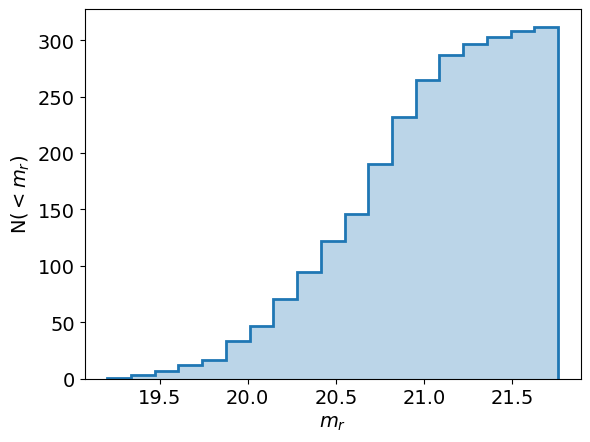

In [19]:
ek.hist( utils.flux2mag(sample['r_cModelFlux_Merian']), cumulative=True, alpha=0.3, lw=2)
plt.xlabel(r'$m_r$')
plt.ylabel(r'N$(<m_r)$')


In [20]:
#ms.loc[is_lmass].to_csv('/Users/kadofong/Downloads/full_masscomplete_sample.csv')

In [16]:
dlum = cosmo.luminosity_distance(0.1).to(u.cm).value
lha_expected = calibrations.SFR2LHa(10.**sample['logsfr']) 
fha_expected = lha_expected / (4.*np.pi*dlum**2)
r_absmag = utils.flux2mag(sample['r_cModelFlux_Merian']) - cosmo.distmod(0.08).value
ewha_expected = calibrations.EWfromLHa(lha_expected, r_absmag, )
sample['expected_haew'] = ewha_expected

In [17]:
sample.to_csv(f'{sample_name}/target_list.csv')

In [10]:
ostars = planning.find_blindoffset_stars(coords[is_observable], maglim=17)

INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


In [19]:
ostars.to_csv(f'{sample_name}/blind_offset_stars.csv')

In [11]:
for idx in range(len(sample)):
    target = sample.iloc[idx]
    query.get_legacysurveyimage(
        target['RA'], target['DEC'], 
        savedir=f'./{sample_name}/thumbnails/', savename=sample.index[idx], pixscale=0.26, width=200, height=200, format='jpg'
    )


Saving:
https://www.legacysurvey.org/viewer/cutout.jpg?ra=33.222069613082795&dec=-6.431757352571157&layer=ls-dr9&pixscale=0.26&width=200&height=200
to ./MassComplete/thumbnails/M2950244784020665799.jpg
Saving:
https://www.legacysurvey.org/viewer/cutout.jpg?ra=34.87384196984972&dec=-6.144657254871133&layer=ls-dr9&pixscale=0.26&width=200&height=200
to ./MassComplete/thumbnails/M2950675792578767836.jpg
Saving:
https://www.legacysurvey.org/viewer/cutout.jpg?ra=34.92193960012602&dec=-6.112787900648346&layer=ls-dr9&pixscale=0.26&width=200&height=200
to ./MassComplete/thumbnails/M2950675792578772244.jpg
Saving:
https://www.legacysurvey.org/viewer/cutout.jpg?ra=34.9175928620035&dec=-6.0497402078601175&layer=ls-dr9&pixscale=0.26&width=200&height=200
to ./MassComplete/thumbnails/M2950675792578778840.jpg
Saving:
https://www.legacysurvey.org/viewer/cutout.jpg?ra=33.62645933229555&dec=-6.137009770905149&layer=ls-dr9&pixscale=0.26&width=200&height=200
to ./MassComplete/thumbnails/M295070657890433827

In [12]:
for idx in range(len(sample)):
    ostar = ostars.iloc[idx]
    query.get_legacysurveyimage(ostar['ra'], ostar['dec'], savedir=f'./{sample_name}/cutouts/', 
                                savename=sample.index[idx], pixscale=1., width=300, height=300, verbose=False)

In [15]:
for ridx in range(len(sample)):
    ostar = ostars.iloc[ridx]
    name = sample.index[ridx]
    cutout = fits.open(f'./{sample_name}/cutouts/{name}.fits')[0]
    cutout_wcs = wcs.WCS(cutout.header)
    
    row = sample.iloc[ridx]
    name = row.name
    
    fig = plt.figure(figsize=(13, 4))
    ax = fig.add_subplot(1,3,1)
    
    alt_l_index = np.arange(len(alt_l), dtype=int)[is_observable][ridx]
    ax.plot(obsframe.obstime.datetime, alt_l[alt_l_index].alt, 'o')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    #ax.set_xtic(rotation=45)
    tw = ax.twinx()
    tw.plot(obsframe.obstime.datetime, alt_l[alt_l_index].secz, 'o', color='C1')
    tw.set_ylim(1.,3.)
    tw.set_ylabel('airmass', color='C1', rotation=270, labelpad=20)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel('Time [UTC]')
    ax.set_ylabel('altitude', color='C0')
    
    
    ek.text(
        0.025,
        0.975,
        r'%s' % row.name,
        ax=ax,
        fontsize=10,
        bordercolor='w',
        borderwidth=2
    )
    
    ax.spines.left.set_color("C0")

    
    ax=fig.add_axes(132, projection=cutout_wcs.celestial)
    ek.imshow(cutout.data[0],origin='lower', cmap='Greys', q=0.0025, ax=ax)
    
    msize = 20
    ek.celestial_plot(sample.iloc[ridx]['RA'], sample.iloc[ridx]['DEC'], ax, marker='o', markeredgecolor='lime', markerfacecolor='None', markersize=msize)
    ek.celestial_plot(ostar['ra'], ostar['dec'], ax, marker='o', markeredgecolor='cyan', markerfacecolor='None', markersize=msize)
    
    ek.text(0.025, 0.975, 'Offset Star', color='cyan', ax=ax, bordercolor='w', borderwidth=3)
    ek.text(0.025, 0.905, 'Science Target', color='lime', ax=ax, bordercolor='w', borderwidth=3)


    ras = [sample.iloc[ridx]['RA'], ostar['ra']]
    decs = [sample.iloc[ridx]['DEC'],ostar['dec']]
    ek.celestial_plot( ras, decs, ax, color='r', lw=0.2, ls=':' )
    ek.text(
        np.mean(ras),
        np.mean(decs),
        r"%i''" % ostar.distance_arcsec,
        color='tab:red',
        coord_type='absolute',
        bordercolor='w',
        borderwidth=2,
        transform=ax.get_transform('fk5'),
        ax=ax
    )
        
    
    ax.grid(color='white', ls=':')
    ax.set_xlabel('RA [J2000]')
    ax.set_ylabel('DEC [J2000]')
    

    imax = fig.add_axes(133)
    thumbnail = mpimg.imread(f'./{sample_name}/thumbnails/{name}.jpg')
    imax.imshow(thumbnail)
    imax.axis('off')
    fha = fha_from_sfr(row)
    fha_oom = np.floor(np.log10(fha))

    ek.text(
        0.025,
        0.975,
        r'''$m_r = %.1f$
$m_{N708}=%.1f$
$F_{\rm H\alpha}^{\rm est} = %.2f\times 10^{%i} \frac{\rm erg}{\rm s\ cm^{2}}$'''%(
            utils.flux2mag(row['r_cModelFlux_Merian']),
            utils.flux2mag(row['N708_cModelFlux_Merian']),
            fha / 10.**fha_oom,
            fha_oom
        ),
        ax=imax,
        color='w',
        fontsize=12
    )
    plt.tight_layout ()
    
    pos = imax.get_position ()
    new_pos = [pos.x0 - 0.1, pos.y0, pos.width, pos.height]
    imax.set_position (new_pos)

    plt.savefig(f'./{sample_name}/finding_charts/{name}.png')
    plt.close()

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_87985/3282180528.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_87985/3282180528.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_87985/3282180528.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_87985/3282180528.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_87985/3282180528.py:23: UserWarning: FixedFormatter should only be used together with